# Train a MLP in MNIST Dataset

In [1]:
import torch
import torchvision
##
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
##
import matplotlib.pyplot as plt

## Download data

In [2]:
batch_size_train = 32
batch_size_test = 1000

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

## Visualize some examples

Let's extract a batch of examples and visualize some of them.

In [4]:
examples = enumerate(test_loader)
batch_idx, (example, label) = next(examples)

In [5]:
example.shape

torch.Size([1000, 1, 28, 28])

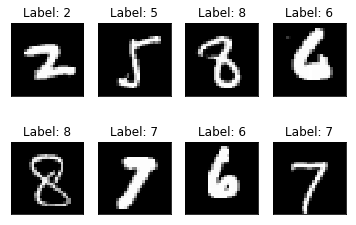

In [6]:
fig = plt.figure()
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(example[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Train MLP

First of all, define the forward pass. We propose to use one hidden FC layer with 50 units, and an output layer with `log_softmax` activation, but feel free to create the network you prefer!

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

Now, we initialize the network and choose the optimizer. We propose using SGD optimizer. Set the `learning_rate` to 0.01 and the `momentum` to 0.5.

In [8]:
learning_rate = 0.01
momentum = 0.5
mlp = MLP()
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate,
                      momentum=momentum)

Now let's train the model during 3 epochs. For monitoring purposes, print the training loss every 100 batches and store it.

In [9]:
n_epochs = 10
train_losses = []
printing_interval = 100
for epoch in range(1, n_epochs + 1):
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad() ## zero the gradients in each pass!
    output = mlp(data) ## forward pass of each batch
    loss = F.nll_loss(output, target) ## compute loss
    loss.backward() ## Backpropagate the gradients
    optimizer.step() ## Update the parameters
    ##
    if batch_idx % printing_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())

/home/roi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330635
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.884813
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.237693
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.348603
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.215347
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.404019
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.497935
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.562738
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.279279
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.388876
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.202214
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.227398
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.065144
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.238217
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.156617
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.186698
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.276182
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.074131
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.264180
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.087495
Train Epoch: 2

KeyboardInterrupt: 

Now, let's plot the negative log likelihood.

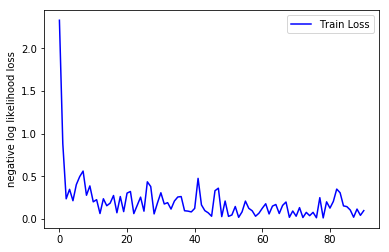

In [10]:
fig = plt.figure()
plt.plot(range(len(train_losses)), train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.ylabel('negative log likelihood loss')
fig

## Evaluate the model in test data

In [13]:
test_loss = 0
number_of_correct = 0
predictions = torch.empty(10, 1000, 1)
i=0
with torch.no_grad():
    for data, target in test_loader:
        output = mlp(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        predictions[i] = pred
        number_of_correct += pred.eq(target.data.view_as(pred)).sum()
        i+=1
    test_loss /= len(test_loader.dataset)
    print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, number_of_correct, len(test_loader.dataset),
    100. * number_of_correct / len(test_loader.dataset)))

/home/roi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/home/roi/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: 0.1138, Accuracy: 9651/10000 (96%)



## Can we improve using regularization?